In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk #natural language toolkit, for tokenization

In [129]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [130]:
spotify_data = pd.read_csv('../data/spotify_millsongdata.csv')
# spotify_data.head()
small_spotify_data = spotify_data.iloc[:10000].copy()
small_spotify_data.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [131]:

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)


{'through', 'mightn', 're', 'do', "he'd", 'his', 'will', "shan't", 'was', 'were', 'but', 'yours', "they'll", 'yourself', 'what', 'has', 'wasn', 'y', "it's", 'an', 'where', "you're", 'on', 'and', "hadn't", 'he', "they've", 'a', 'before', "you'd", 'them', 'ain', "hasn't", "we'd", 'few', 'by', 'now', 'some', 'my', "weren't", 'here', 'until', "i'm", "mightn't", 'won', 'their', 'should', 'had', 'from', "i've", 'ourselves', 'after', 'this', "mustn't", 'me', 'no', 'our', "couldn't", 'll', 'only', 'be', "aren't", "shouldn't", "wouldn't", "she's", 'than', 'herself', "needn't", 'too', 'needn', 'don', "wasn't", 'doing', 'each', 'because', "it'll", 'of', 'its', 'over', 'am', 'himself', 'they', "should've", "haven't", 'her', 'yourselves', 'is', 'off', 'same', 'there', 'when', 'isn', 'most', 'about', 'having', "they'd", "won't", 'into', 'if', 'didn', 'hadn', 'itself', 'theirs', 'whom', "you'll", "i'd", 'with', 'we', "didn't", 'the', 'she', "it'd", 'shan', 'then', 'between', 'during', 'o', "that'll",

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aakashshrestha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
#check for any null entries
small_spotify_data.isna().sum().sort_values(ascending=True)

artist    0
song      0
link      0
text      0
dtype: int64

In [133]:
def clean_text(text):
    text = str(text).lower() #lower case
    text = re.sub(r'\r\n', ' ', text) #remove new lines
    text = re.sub(r'[^a-z\s]', '', text) #remove special chars/numbers
    tokens = text.split() #tokenize
    tokens = [t for t in tokens if t not in stop_words] #remove unwanted stopwords
    return ' '.join(tokens)

In [134]:
#clean the spotify dataframe
small_spotify_data['cleaned_lyrics'] = spotify_data['text'].apply(clean_text) #apply clean_text function to clean the data
small_spotify_data[['song', 'cleaned_lyrics']].head(10)


,song,cleaned_lyrics
0,Ahe's My Kind Of Girl,look face wonderful face means something speci...
1,"Andante, Andante",take easy please touch gently like summer even...
2,As Good As New,ill never know go put lousy rotten show boy to...
3,Bang,making somebody happy question give take learn...
4,Bang-A-Boomerang,making somebody happy question give take learn...
5,Burning My Bridges,well hoot holler make mad ive always heel holy...
6,Cassandra,street theyre singing shouting staying alive t...
7,Chiquitita,chiquitita tell whats wrong youre enchained so...
8,Crazy World,morning sun couldnt sleep thought id take walk...
9,Crying Over You,im waitin baby im sitting alone feel cold with...



TF-IDF
Tf : Term Frequency - how often does the word appears in the document
IDF : Inverse Document Frequency - how rare that word is across all songs
<br>
$TF-IDF = TF * IDF$ => It gives high weight to words that are important to one song but not common in all song

In [135]:
#TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(small_spotify_data['cleaned_lyrics'])
X_tfidf.shape
print(X_tfidf.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.05986668 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.01870398 0.        ]
 [0.         0.         0.         ... 0.         0.08284241 0.        ]
 [0.         0.         0.         ... 0.1527957  0.         0.        ]]


In [136]:
#PCA dimension reduction before kmeans clustering
X_pca = PCA(n_components=50).fit_transform(X_tfidf)

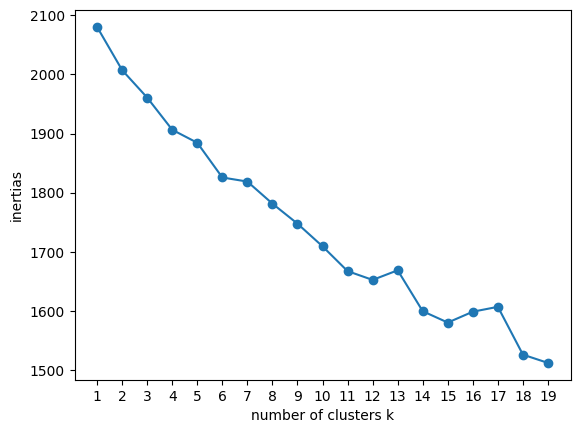

In [137]:
#elbow to find inertia
ks = range(1,20)
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters k')
plt.ylabel('inertias')
plt.xticks(ks)
plt.show()
    
    

In [138]:
#KMeans clustering
kmeans = KMeans(n_clusters=8, random_state=7)
kmeans.fit(X_pca)
small_spotify_data['cluster'] = kmeans.predict(X_pca)

#view the clusters
small_spotify_data[['artist', 'song', 'cluster']].head(10)


,artist,song,cluster
0,ABBA,Ahe's My Kind Of Girl,0
1,ABBA,"Andante, Andante",3
2,ABBA,As Good As New,7
3,ABBA,Bang,7
4,ABBA,Bang-A-Boomerang,7
5,ABBA,Burning My Bridges,1
6,ABBA,Cassandra,0
7,ABBA,Chiquitita,0
8,ABBA,Crazy World,3
9,ABBA,Crying Over You,1


In [139]:
#Cosine similarity-based recommendation
cos_sim = cosine_similarity(X_pca)

#define a function that returns the recommendation  : main algooo
def recommend(index, no_recommendations=5): #no_recommendations: how many songs to recommend
    sim_scores = list(enumerate(cos_sim[index])) #converts enumerate object (index, value) into list : index: song_index, value: cos_sim score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) #key specifies on what basis the sorting should be done, here tuple's second index, ie. score
    top_indices = [i for i, score in sim_scores[1:no_recommendations+1]]
    return spotify_data.iloc[top_indices][['artist', 'song']]


In [140]:
#dimensionality reduction using TSNE
n = small_spotify_data.shape[0] #no of rows
tsne = TSNE(learning_rate=n/12) #rule of thumb for learning_rate hyperparameter

X_tsne = tsne.fit_transform(X_pca)

#Add x_tsne to spotify_data dataframe
small_spotify_data['xs'] = X_tsne[:,0]
small_spotify_data['ys'] = X_tsne[:,1]


In [141]:
#test of recommendation system hahah
small_spotify_data.iloc[200][['artist', 'song']]
# recommend(200)

artist        Aerosmith
song      She's On Fire
Name: 200, dtype: object

In [142]:
small_spotify_data.head()

,artist,song,link,text,cleaned_lyrics,cluster,xs,ys
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA...",look face wonderful face means something speci...,0,23.957066,-63.700222
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen...",take easy please touch gently like summer even...,3,7.215904,-15.214081
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...,ill never know go put lousy rotten show boy to...,7,-44.420620,-21.025757
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...,making somebody happy question give take learn...,7,27.993692,41.964062
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...,making somebody happy question give take learn...,7,28.041239,41.949013


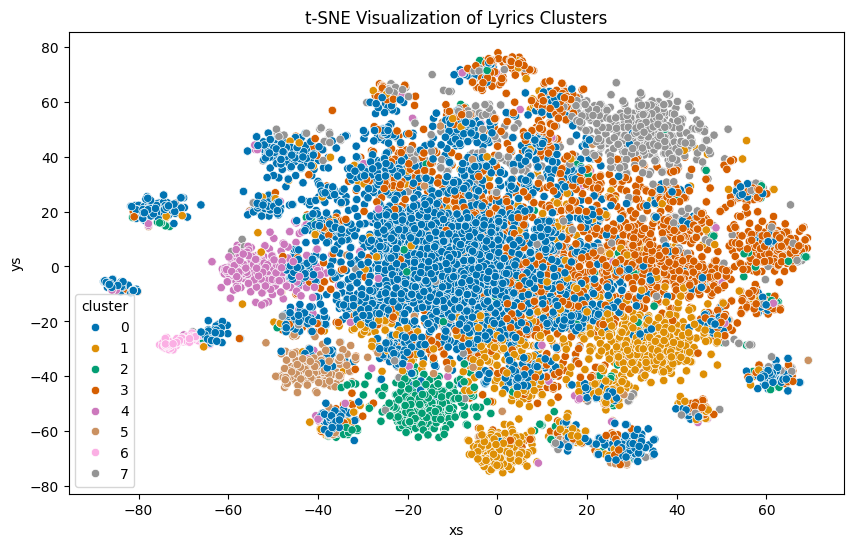

In [143]:
#plot the giraff
plt.figure(figsize=(10,6))
sns.scatterplot(data=small_spotify_data, x='xs', y='ys', hue='cluster', palette='colorblind')
plt.title('t-SNE Visualization of Lyrics Clusters')
plt.show()

In [144]:
#silhouette_score for measuring cluster quality
from sklearn.metrics import silhouette_score
score = silhouette_score(X_pca, kmeans.labels_)
print("Silhouette Score:", score)

Silhouette Score: 0.06897802969998292
